In [12]:
import geopandas as gpd
import sys
sys.path.append('..')  # Add the parent directory to the system path if needed
sys.path.append('...')


# # Load in topo data from txt file
# topo = pd.read_csv('/Users/leoglonz/Desktop/camels_topo.txt', delimiter=';')

# Load in HUC02 reg2 shapefile
data = gpd.read_file('data/Region_02_nhru_simplify_100/Region_02_nhru_simplify_100.shp')

In [5]:
sorted_gages = data[['GAGEID', 'Shape_Area']].sort_values(ascending=False, by='Shape_Area').reset_index()

# count the number of HRU in each gageid
data_grouped = (
    data[['GAGEID', 'Shape_Area']]
    .groupby('GAGEID')
    .agg(
        count=('GAGEID', 'size'),  # Count the number of rows per GAGEID
        total_shape_area=('Shape_Area', 'sum')  # Sum the Shape_Area values
    )
    .reset_index()  # Reset index to get a clean DataFrame
    .sort_values(by='count', ascending=False)  # Sort by count in descending order
).reset_index()

print(data_grouped)

# Select GAGID 01664000 with the most subgages
gage_ex = data[data['GAGEID'] == '01664000'][['hru_id', 'GAGEID', 'hru_x', 'hru_y', 'geometry']]
gage_ex['centroid'] = gage_ex.geometry.centroid  # Calculate the centroid of each geometry (can also select .x and .y)

gage_ex.head()

    index    GAGEID  count  total_shape_area
0      58  01664000     30      1.604665e+09
1      29  01543500     29      1.778997e+09
2      48  01606500     24      1.686645e+09
3       9  01423000     23      8.617984e+08
4      28  01543000     19      7.044858e+08
..    ...       ...    ...               ...
70     38  01557500      1      1.177820e+08
71     39  01567500      1      3.950381e+07
72     43  01586610      1      7.280919e+07
73     44  01591400      1      5.960995e+07
74     74  02038850      1      2.380165e+07

[75 rows x 4 columns]


,hru_id,GAGEID,hru_x,hru_y,geometry,centroid
315,676,01664000,1.555475e+06,1.871388e+06,"POLYGON ((1557585.032 1873821.579, 1558713.209...",POINT (1555471.93 1871381.067)
316,677,01664000,1.556985e+06,1.873202e+06,"POLYGON ((1557705.164 1873634.862, 1557135.208...",POINT (1557157.422 1873302.184)
317,682,01664000,1.524709e+06,1.866803e+06,"POLYGON ((1515285.084 1874594.839, 1515463.46 ...",POINT (1524698.841 1866801.807)
318,684,01664000,1.559351e+06,1.873544e+06,"POLYGON ((1559144.994 1875135.042, 1559174.674...",POINT (1559344.881 1873551.626)
319,687,01664000,1.532652e+06,1.866810e+06,"POLYGON ((1525844.723 1875045.026, 1526085.064...",POINT (1530455.834 1869619.296)


(<Axes: >, <Axes: >)

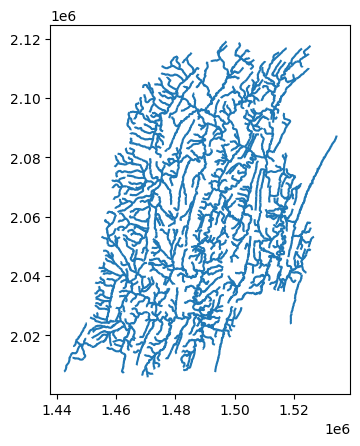

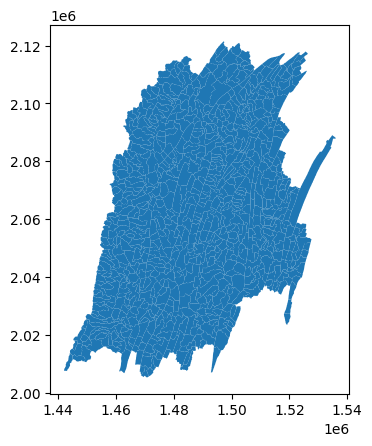

In [6]:
### Get Juniata river basin (JRB) data
# 'flowpaths', 'nexus', 'divides', 'lakes', 'network', 'divide-attributes', 'flowpath-attributes', 'flowpath-attributes-ml'
path = 'data/jrb.gpkg'
flowpaths = gpd.read_file(path, layer='flowpaths')
divides = gpd.read_file(path, layer='divides')
nexus = gpd.read_file(path, layer='nexus')
flowpaths.plot(), divides.plot()

In [7]:
boundary = divides.union_all()
boundary.bounds

(1442054.9997, 2005274.9997, 1536014.9997, 2121495.0003)

In [8]:
import numpy as np
from shapely.geometry import Point
import random

# Fix randomness for reproducibility
np.random.seed(42)
random.seed(42)


N_GAGES = 100

# Generate random points within the bounding box of the region.
bounding_box = boundary.bounds  # [xmin, ymin, xmax, ymax]
random_points = np.random.uniform(
    low=[bounding_box[0], bounding_box[1]],
    high=[bounding_box[2], bounding_box[3]],
    size=(N_GAGES * 10, 2),  # Generate extra to ensure enough are within the region.
)

points = [Point(x, y) for x, y in random_points]

# Filter points that are inside the region.
inside_points = [point for point in points if boundary.contains(point)]

# Keep only the desired number of gages
points0 = inside_points[:N_GAGES]

print(f"Selected {len(points0)} points inside the region.")

Selected 100 points inside the region.


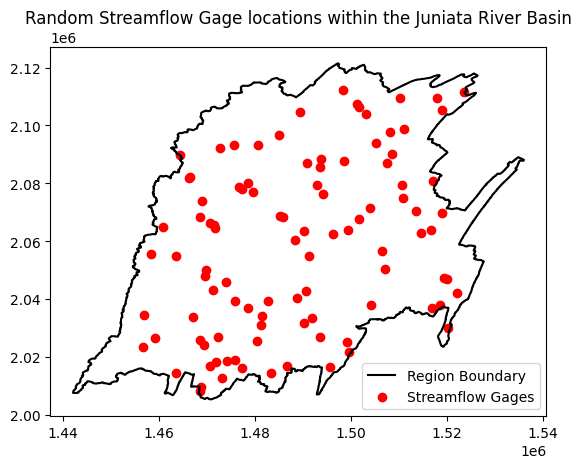

In [9]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon


# Plot the region boundary
if isinstance(boundary, Polygon):
    plt.plot(*boundary.exterior.xy, color='black', label='Region Boundary')
elif isinstance(boundary, MultiPolygon):
    for geom in boundary.geoms:
        plt.plot(*geom.exterior.xy, color='black', label='Region Boundary')

# Plot the optimized points
plt.scatter(
    [p.x for p in points0],
    [p.y for p in points0],
    color='red',
    label='Streamflow Gages',
)

plt.title('Random Streamflow Gage locations within the Juniata River Basin')
plt.legend()
plt.show()

In [31]:
### Interactive Folium plot ###
import os
import folium
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output



# Create a gdf for the points
gdf_points = gpd.GeoDataFrame(geometry=[Point(p) for p in points0], crs="EPSG:5070")

# Reproject to EPSG:4326 for folium
gdf_points = gdf_points.to_crs(epsg=4326)
gdf_boundary = divides.to_crs(epsg=4326)
gdf_boundary = gdf_boundary.union_all()
gdf_rivers = flowpaths.to_crs(epsg=4326)

# Get river segment density
scaler = MinMaxScaler(feature_range=(1, 50))
gdf_rivers['density'] = gdf_rivers['areasqkm'] / gdf_rivers['lengthkm']
gdf_rivers['scaled_density'] = scaler.fit_transform(gdf_rivers[['density']])

# Create a map centered on boundary area
centroid = gdf_boundary.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=12)

folium.GeoJson(
    gdf_boundary,
    style_function=lambda x: {'color': 'black', 'weight': 2, 'fillOpacity': 0.1},
).add_to(m)

# folium.GeoJson(
#     gdf_rivers,
#     style_function=lambda x: {'color': 'blue', 'weight': 0.9, 'fillOpacity': 0.2},
# ).add_to(m)

for _, row in gdf_rivers.iterrows():
    folium.PolyLine(
        locations=[(point[1], point[0]) for point in row.geometry.coords],
        weight=row['scaled_density']*0.2,  # Use scaled density for line width
        color='blue',
        opacity=0.7
    ).add_to(m)
    
for point in gdf_points.geometry:
    folium.CircleMarker(
        location=[point.y, point.x],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5,
        popup=f"Coordinates: ({point.x:.4f}, {point.y:.4f})",        
    ).add_to(m)

os.makedirs('output', exist_ok=True)
m.save('output/starting_gage_map.html')
m

In [32]:
def live_plot(points0, points_pred, boundary, flowpaths=None, figsize=(10,10)):
    clear_output(wait=True)
    plt.figure(figsize=figsize)

    # Plot the region boundary
    if isinstance(boundary, Polygon):
        plt.plot(*boundary.exterior.xy, color='black', label='Region Boundary')
    elif isinstance(boundary, MultiPolygon):
        for geom in boundary.geoms:
            plt.plot(*geom.exterior.xy, color='black', label='Region Boundary')

    if flowpaths is not None:
        for _, row in flowpaths.iterrows():
            if row.geometry.geom_type == 'LineString':
                x, y = row.geometry.xy
                plt.plot(x, y, color='blue', linewidth=0.5, label='River' if not plt.gca().lines else None)
            elif row.geometry.geom_type == 'MultiLineString':
                for line in row.geometry.geoms:
                    x, y = line.xy
                    plt.plot(x, y, color='blue', linewidth=0.5, label='River' if not plt.gca().lines else None)

    # Plot the optimized points
    plt.scatter(
        [p.x for p in points0],
        [p.y for p in points0],
        color='red',
        label='Initial',
        s=10,
    )
    plt.scatter(
        [p.x for p in points_pred],
        [p.y for p in points_pred],
        color='blue',
        alpha=0.6,
        label='Final',
        s=10,
    )

    plt.title('Locating Streamflow Gages within the Juniata River Basin')
    plt.legend(loc='upper left')
    plt.show()

In [33]:
import random
import numpy as np
from scipy.spatial.distance import pdist
from shapely.affinity import scale
from shapely.geometry import MultiLineString
from rtree import index
from functools import lru_cache

import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler()]
)



def precompute_distances(points, network, spatial_index, max_distance):
    """
    Precompute distances from points to river segments.
    Parameters:
    - points: List of Shapely Point objects.
    - network: List of Shapely LineString objects representing the river network.
    - spatial_index: R-tree index for the river network.
    - max_distance: Maximum acceptable distance to a river.
    Returns:
    - A dictionary mapping each point to its nearest river segment and distance.
    """
    point_distances = {}
    for point in points:
        candidate_indices = list(spatial_index.intersection(point.buffer(max_distance).bounds))
        min_distance = float('inf')
        closest_river = None
        for idx in candidate_indices:
            dist = network[idx].distance(point)
            if dist < min_distance and dist <= max_distance:
                min_distance = dist
                closest_river = network[idx]
        point_distances[point] = (closest_river, min_distance)  # Use Point object as key
    return point_distances


def update_distances(moved_point, new_position, point_distances, network, spatial_index, max_distance):
    """
    Update the precomputed distances after moving a point.
    Parameters:
    - moved_point: The point that was moved (Shapely Point object).
    - new_position: The new position of the moved point (Shapely Point object).
    - point_distances: Dictionary of precomputed distances.
    - network: List of Shapely LineString objects representing the river network.
    - spatial_index: R-tree index for the river network.
    - max_distance: Maximum acceptable distance to a river.
    Returns:
    - Updated point_distances dictionary.
    """
    network = [geom for geom in network.geometry if geom.geom_type in ['LineString', 'MultiLineString']]
    candidate_indices = list(spatial_index.intersection(new_position.buffer(max_distance).bounds))
    min_distance = float('inf')
    closest_river = None
    for idx in candidate_indices:
        dist = network[idx].distance(new_position)
        if dist < min_distance and dist <= max_distance:
            min_distance = dist
            closest_river = network[idx]
    point_distances[moved_point] = (closest_river, min_distance)  # Use Point object as key
    return point_distances


# def objective_distance(points, boundary, boundary_buffer=100):
#     # Penalty for distanc between points
#     distances = pdist(points)
#     min_distance = np.min(distances) if len(distances) > 0 else 0

#     # # Penalty for points too close to the boundary
#     # boundary_penalty = 0
#     # for point in points:
#     #     dist_to_boundary = boundary.distance(Point(point))
#     #     if dist_to_boundary < boundary_buffer:
#     #         boundary_penalty += (boundary_buffer - dist_to_boundary)

#     score = -min_distance #- boundary_penalty * 5
#     return score


def objective_distance(points, point_distances, boundary, boundary_buffer=100):
    """
    Calculate the penalty for distances between points and their proximity to the boundary.
    Parameters:
    - points: List of Shapely Point objects.
    - point_distances: Dictionary mapping each point to its nearest neighbor and distance.
    - boundary: Shapely geometry representing the region boundary.
    - boundary_buffer: Buffer distance from the boundary.
    Returns:
    - Penalty score based on distances.
    """
    # Find the minimum distance using precomputed distances
    min_distance = float('inf')
    for point in points:
        _, dist = point_distances.get(point, (None, float('inf')))
        if dist < min_distance:
            min_distance = dist

    # Optional: Add penalty for points too close to the boundary
    boundary_penalty = 0
    for point in points:
        dist_to_boundary = boundary.distance(Point(point))
        if dist_to_boundary < boundary_buffer:
            boundary_penalty += (boundary_buffer - dist_to_boundary)

    score = -min_distance #- boundary_penalty * 5
    return score


@lru_cache(maxsize=None)
def create_spatial_index(rivers):
    """
    Create a spatial index for the river network.

    Parameters:
    - rivers: List of Shapely LineString objects representing river flow lines.

    Returns:
    - An R-tree index for the river network.
    """
    idx = index.Index()
    for i, river in enumerate(rivers):
        if not hasattr(river, 'bounds'):
            raise ValueError(f"Invalid geometry at index {i}: {river}")
        idx.insert(i, river.bounds)
    return idx


def assign_points_to_rivers(points, point_distances, rivers, spatial_index, max_distance):
    """
    Assign each point to the nearest river flow line if within max_distance.
    Parameters:
    - points: List of (x, y) coordinates of points.
    - point_distances: Dictionary mapping each point to its nearest river segment and distance.
    - rivers: List of Shapely LineString objects representing river flow lines.
    - spatial_index: R-tree index for the river network.
    - max_distance: Maximum distance for a point to be considered associated with a river.
    Returns:
    - A dictionary mapping each river index to the list of points associated with it.
    """
    river_assignments = {i: [] for i in range(len(rivers))}
    for point_coords in points:
        point = Point(point_coords)  # Convert tuple to Point
        # Find candidate river segments using the spatial index
        candidate_indices = list(spatial_index.intersection(point.buffer(max_distance).bounds))
        min_distance = float('inf')
        closest_river_idx = None
        for idx in candidate_indices:
            # Access point_distances using the Point object
            closest_river, dist = point_distances.get(point, (None, float('inf')))
            if dist < min_distance and dist <= max_distance:
                min_distance = dist
                closest_river_idx = idx
        if closest_river_idx is not None:
            river_assignments[closest_river_idx].append(point_coords)
    return river_assignments


def objective_uniqueness(points, point_distances, network, spatial_index):
    """
    Penalize cases where more than two points are assigned to the same river segment.
    Parameters:
    - points: List of Shapely Point objects.
    - point_distances: Dictionary mapping each point to its nearest river segment and distance.
    - network: List of Shapely LineString objects representing the river network.
    - spatial_index: R-tree index for the river network.
    Returns:
    - Total penalty for overlapping points on the same river segment.
    """
    overlap_penalty = 0
    max_distance = 1000  # Maximum acceptable distance to a river (adjust as needed)

    # Assign points to rivers using the spatial index
    river_assignments = assign_points_to_rivers(
        points, #[Point(x, y) for x, y in points],  # Convert points to Point objects
        point_distances,
        network,
        spatial_index,
        max_distance
    )

    # Penalize rivers with more than two points
    for river_points in river_assignments.values():
        if len(river_points) > 2:
            overlap_penalty += (len(river_points) - 2) * 1000  # Penalty per extra point

    return overlap_penalty


def objective_network(points, network):
    """Enforce streamflow gages on river locations"""
    dist = network.distance(points)
    return sum(dist)


class DistrictMarkovAnnealing:
    def __init__(
        self,
        region_boundary,
        network,
        initial_points,
        n_points,
        temperature=1.0,
        boundary_buffer=10,
    ):
        """Initialize the annealing process.

        Parameters:
        - region_boundary: Shapely geometry representing the region boundary.
        - initial_points: Initial list of (x, y) coordinates for gages.
        - num_gages: Number of gages to place.
        - temperature: Initial temperature for annealing.
        """
        if not hasattr(region_boundary, 'bounds'):
            raise ValueError("region_boundary must be a valid Shapely geometry.")
        if not hasattr(network, 'geometry') or network.geometry.is_empty.any():
            raise ValueError("network must be a GeoDataFrame with non-empty geometries.")
        if len(initial_points) != n_points:
            raise ValueError("initial_points must match the number of points specified by n_points.")

        self.region_boundary = region_boundary
        self.network = network
        self.network_ls = MultiLineString(
            [geom for geom in network.geometry if geom.geom_type in ['LineString', 'MultiLineString']]
        )
        self.spatial_index = create_spatial_index(
            tuple(geom for geom in network.geometry if geom.geom_type == 'LineString')
#[geom for geom in network.geometry if geom.geom_type == 'LineString']
        )
        self.points0 = initial_points.copy()
        self.points = initial_points
        self.n_points = n_points
        self.temperature = temperature
        self.boundary_buffer = boundary_buffer

        # Precompute distances between points and river segments.
        max_distance = 1000  # Maximum acceptable distance to a river
        self.point_distances = precompute_distances(
            initial_points, #[Point(x, y) for x, y in initial_points],
            [geom for geom in network.geometry if geom.geom_type == 'LineString'],
            self.spatial_index,
            max_distance,
        )

    @staticmethod
    def flatten_network(network):
        """
        Flatten MultiLineStrings into LineStrings.
        
        Parameters:
        - network: List of Shapely geometries.
        
        Returns:
        - A list of LineString objects.
        """
        flattened = []
        for geom in network:
            if geom.geom_type == 'MultiLineString':
                flattened.extend(list(geom.geoms))  # Extract individual LineStrings
            elif geom.geom_type == 'LineString':
                flattened.append(geom)
        return flattened

    def objective(self, points):
        """Calculate the objective function based on the current points."""
        # dist = objective_distance(points, self.region_boundary, self.boundary_buffer)
        dist = objective_distance(
            points,  # Convert points to Shapely Point objects
            self.point_distances,
            self.region_boundary,
            self.boundary_buffer
        )
        network_dist = objective_network(
            points, #[Point(x, y) for x, y in points],
            MultiLineString([geom for geom in self.network.geometry])
        )
        uniqueness = objective_uniqueness(
            points,
            self.point_distances,
            [geom for geom in flowpaths.geometry if geom.geom_type in ['LineString', 'MultiLineString']],
            spatial_index=self.spatial_index,
        )

        loss = dist + network_dist + uniqueness
        return loss
    
    def run_iteration(self):
        """Run a single iteration of the annealing process."""
        idx = random.randint(0, self.n_points - 1)
        old_point = self.points[idx]

        bounding_box = self.region_boundary.bounds
        new_point_coords = (
            random.uniform(bounding_box[0], bounding_box[2]),
            random.uniform(bounding_box[1], bounding_box[3]),
        )
        new_point = Point(new_point_coords)  # Convert tuple to Point
        normalized_new_point = Point(new_point.x * 1e-7, new_point.y * 1e-7)

        normalized_boundary = scale(
            self.region_boundary, 
            xfact=1e-7,
            yfact=1e-7,
            origin=(self.region_boundary.centroid.x * 1e-7,
                    self.region_boundary.centroid.y * 1e-7,
            )
        )
        
        # Generate new point meeting criteria.
        while (not self.region_boundary.contains(new_point)) and (not normalized_boundary.distance(normalized_new_point) < self.boundary_buffer):
            # New candidate point within the bounding box
            new_point_coords = (
                random.uniform(bounding_box[0], bounding_box[2]),
                random.uniform(bounding_box[1], bounding_box[3]),
            )
            new_point = Point(new_point_coords)  # Convert tuple to Point
            normalized_new_point = Point(new_point.x * 1e-7, new_point.y * 1e-7)
        
        # Evaluate objective before and after move.
        current_score = self.objective(self.points)
        self.points[idx] = new_point

        # Update the distances for the moved point
        max_distance = 1000  # Maximum acceptable distance to a river
        self.point_distances = update_distances(
            Point(old_point),
            Point(new_point),
            self.point_distances,
            self.network,
            self.spatial_index,
            max_distance,
        )

        new_score = self.objective(self.points)

        # Decide to accept move
        if new_score < current_score:
            return True
        else:
            # Accept worse moves with a probability based on temperature
            diff = new_score - current_score
            accept_probability = np.exp(-diff / max(self.temperature, 0))
            if abs(random.random()) < accept_probability:
                return True
            else:
                # Revert the change
                self.points[idx] = old_point
                # Revert the distances as well
                self.point_distances = update_distances(
                    Point(new_point),
                    Point(old_point),
                    self.point_distances,
                    self.network,
                    self.spatial_index,
                    max_distance,
                )
                return False

    def update_temperature(self, cooling_rate):
        """Update the temperature for simulated annealing."""
        self.temperature *= cooling_rate

    def run_simulation(self, n_iter=10000, cooling_rate=0.99):
        """Run the simulated annealing simulation."""
        for iteration in range(n_iter):


            self.run_iteration()

            # Print progress
            if iteration % 1000 == 0:
                current_score = self.objective(self.points)
                logging.info(f"Iteration {iteration}: Score = {current_score:.2f}, Temperature = {self.temperature:.4f}")

                # print(f"Iteration {iteration}: Score = {current_score:.2f}," \
                    #   f" Temperature = {self.temperature:.4f}")

            self.update_temperature(cooling_rate)

            # live_plot(
            #     self.points0,
            #     self.points,
            #     boundary,
            #     figsize=(6,6),
            # )
        return self.points


mcma_model = DistrictMarkovAnnealing(
    region_boundary=boundary,
    network=flowpaths,
    initial_points=points0.copy(), #[(point.x, point.y) for point in points0],
    n_points=N_GAGES,
    temperature=25,  # Initial temperature
    boundary_buffer=0.1,  # Buffer distance from the boundary
)

points_pred = mcma_model.run_simulation(n_iter=40000, cooling_rate=0.9999)

2025-03-30 11:44:08,551 - INFO - Iteration 0: Score = 58627.69, Temperature = 25.0000
2025-03-30 11:44:43,022 - INFO - Iteration 1000: Score = 8125.78, Temperature = 22.6208


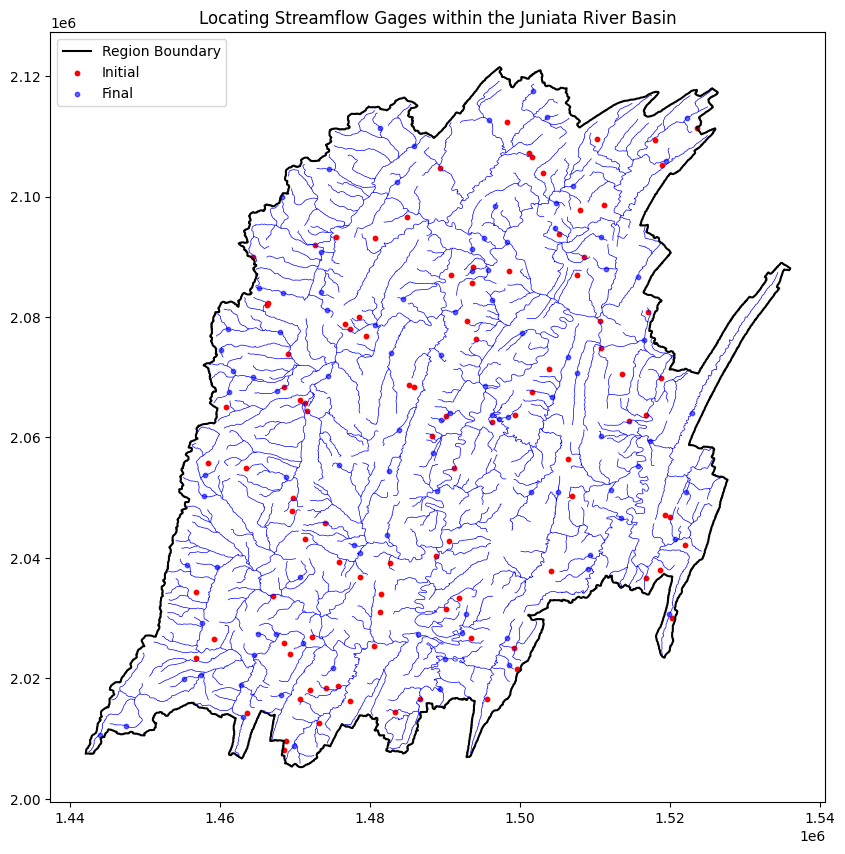

In [64]:
# Save predicted points to a GeoDataFrame for visualization
gdf_points = gpd.GeoDataFrame(geometry=points_pred, crs="EPSG:4326")
# Example: Add an ID column
gdf_points['id'] = range(len(gdf_points))

# Example: Add a score column (if available)
gdf_points['score'] = [mcma_model.objective([point]) for point in points_pred]

gdf_points.to_file("output/points_pred_new.geojson", driver="GeoJSON")

live_plot(
    points0,
    points_pred,
    boundary,
    flowpaths,
)

In [60]:
### Interactive Folium plot ###
import folium
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output


# Create a gdf for the points
gdf_points = gpd.GeoDataFrame(geometry=points_pred, crs="EPSG:5070")

# Reproject to EPSG:4326 for folium
gdf_points = gdf_points.to_crs(epsg=4326)
gdf_boundary = divides.to_crs(epsg=4326)
gdf_boundary = gdf_boundary.union_all()
gdf_rivers = flowpaths.to_crs(epsg=4326)

# Get river segment density
scaler = MinMaxScaler(feature_range=(1, 50))
gdf_rivers['density'] = gdf_rivers['areasqkm'] / gdf_rivers['lengthkm']
gdf_rivers['scaled_density'] = scaler.fit_transform(gdf_rivers[['density']])

# Create a map centered on boundary area
centroid = gdf_boundary.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=12)

folium.GeoJson(
    gdf_boundary,
    style_function=lambda x: {'color': 'black', 'weight': 2, 'fillOpacity': 0.1},
).add_to(m)

# folium.GeoJson(
#     gdf_rivers,
#     style_function=lambda x: {'color': 'blue', 'weight': 0.9, 'fillOpacity': 0.2},
# ).add_to(m)

for _, row in gdf_rivers.iterrows():
    folium.PolyLine(
        locations=[(point[1], point[0]) for point in row.geometry.coords],
        weight=row['scaled_density']*0.2,  # Use scaled density for line width
        color='blue',
        opacity=0.7
    ).add_to(m)
    
for point in gdf_points.geometry:
    folium.CircleMarker(
        location=[point.y, point.x],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5,
        popup=f"Coordinates: ({point.x:.4f}, {point.y:.4f})",        
    ).add_to(m)

m.save('output/final_gage_dist_map.html')
# m

In [ ]:
##### USE VERSION ABOVE #######

import random
import numpy as np
from scipy.spatial.distance import pdist
from shapely.affinity import scale
from shapely.geometry import MultiLineString
from shapely.geometry import Point, box
from rtree import index


def assign_points_to_rivers(points, rivers, max_distance):
    """
    Assign each point to the nearest river flow line if within max_distance.
    
    Parameters:
    - points: List of (x, y) coordinates of points.
    - rivers: List of Shapely LineString objects representing river flow lines.
    - max_distance: Maximum distance for a point to be considered associated with a river.
    
    Returns:
    - A dictionary mapping each river index to the list of points associated with it.
    """
    river_assignments = {i: [] for i in range(len(rivers))}
    for point in points:
        min_distance = float('inf')
        closest_river_idx = None
        for idx, river in enumerate(rivers):
            dist = river.distance(Point(point))
            if dist < min_distance and dist <= max_distance:
                min_distance = dist
                closest_river_idx = idx
        if closest_river_idx is not None:
            river_assignments[closest_river_idx].append(point)
    return river_assignments


def objective_distance(points, boundary, boundary_buffer=100):
    # Penalty for distanc between points
    distances = pdist(points)
    min_distance = np.min(distances) if len(distances) > 0 else 0

    # # Penalty for points too close to the boundary
    # boundary_penalty = 0
    # for point in points:
    #     dist_to_boundary = boundary.distance(Point(point))
    #     if dist_to_boundary < boundary_buffer:
    #         boundary_penalty += (boundary_buffer - dist_to_boundary)

    score = -min_distance #- boundary_penalty * 5
    return score


def create_spatial_index(rivers):
    """
    Create a spatial index for the river network.

    Parameters:
    - rivers: List of Shapely LineString objects representing river flow lines.

    Returns:
    - An R-tree index for the river network.
    """
    idx = index.Index()
    for i, river in enumerate(rivers):
        idx.insert(i, river.bounds)
    return idx


def objective_network(points, network, spatial_index, max_distance=1000):
    """
    Enforce streamflow gages on river locations by penalizing points far from rivers.

    Parameters:
    - points: List of Shapely Point objects.
    - network: List of Shapely LineString objects representing the river network.
    - spatial_index: R-tree index for the river network.
    - max_distance: Maximum acceptable distance to a river (adjust as needed).

    Returns:
    - Total penalty for points far from rivers.
    """
    penalty = 0

    for point in points:
        # Find candidate river segments using the spatial index
        candidate_indices = list(spatial_index.intersection(point.buffer(max_distance).bounds))
        if candidate_indices:
            # Calculate the minimum distance to candidate river segments
            min_dist = min(network[i].distance(point) for i in candidate_indices)
            if min_dist > max_distance:
                penalty += (min_dist - max_distance)
        else:
            # No river segments within max_distance
            penalty += max_distance

    return penalty



def objective_nexus(points, network):
    """
    Penalize cases where more than two points are assigned to the same river segment.

    Parameters:
    - points: List of Shapely Point objects.
    - network: List of Shapely LineString or MultiLineString objects representing the river network.

    Returns:
    - Total penalty for overlapping points on the same river segment.
    """
    overlap_penalty = 0
    max_distance = 1000  # Maximum acceptable distance to a river (adjust as needed)

    # Assign points to rivers
    river_assignments = assign_points_to_rivers(points, network, max_distance)

    # Penalize rivers with more than two points
    for river_points in river_assignments.values():
        if len(river_points) > 2:
            overlap_penalty += (len(river_points) - 2) * 1000  # Penalty per extra point

    return overlap_penalty


class DistrictMarkovAnnealing:
    def __init__(
        self,
        region_boundary,
        network,
        initial_points,
        n_points,
        temperature=1.0,
        boundary_buffer=10,
    ):
        """Initialize the annealing process.

        Parameters:
        - region_boundary: Shapely geometry representing the region boundary.
        - initial_points: Initial list of (x, y) coordinates for gages.
        - num_gages: Number of gages to place.
        - temperature: Initial temperature for annealing.
        """
        self.region_boundary = region_boundary
        self.network = network
        self.spatial_index = create_spatial_index(network)  # Create spatial index
        self.points0 = initial_points.copy()
        self.points = initial_points
        self.n_points = n_points
        self.temperature = temperature
        self.boundary_buffer = boundary_buffer

        self.accept_count = 0

    def objective(self, points):
        """Calculate the objective function based on the current points."""
        dist = objective_distance(points, self.region_boundary, self.boundary_buffer)
        network_dist = objective_network(
            [Point(x, y) for x, y in points], 
            self.network, 
            self.spatial_index
        )
        # overlap = objective_nexus([Point(x, y) for x, y in points], self.network)
        loss = dist + network_dist
        return loss
    
    def run_iteration(self):
        """Run a single iteration of the annealing process."""
        idx = random.randint(0, self.n_points - 1)
        old_point = self.points[idx]

        bounding_box = self.region_boundary.bounds
        new_point = (
            random.uniform(bounding_box[0], bounding_box[2]),
            random.uniform(bounding_box[1], bounding_box[3])
        )

        normalized_boundary = scale(
            self.region_boundary, 
            xfact=1e-7,
            yfact=1e-7,
            origin=(self.region_boundary.centroid.x * 1e-7,
                    self.region_boundary.centroid.y * 1e-7,
            )
        )
        
        # Generate new point meeting criteria.
        while (not self.region_boundary.contains(Point(new_point))) and (not normalized_boundary.distance(Point(tuple(coord*1e-7 for coord in new_point))) < self.boundary_buffer):
            # New candidate point within the bounding box
            new_point = (
                random.uniform(bounding_box[0], bounding_box[2]),
                random.uniform(bounding_box[1], bounding_box[3]),
            )

        # Evaluate objective before and after move.
        current_score = self.objective(self.points)
        self.points[idx] = new_point
        new_score = self.objective(self.points)

        # Decide to accept move
        if new_score < current_score:
            return True
        else:
            # Accept worse moves with a probability based on temperature
            diff = new_score - current_score
            accept_probability = np.exp(-diff / max(self.temperature, 0))
            if abs(random.random()) < accept_probability:
                self.accept_count += 1
                return True
            else:
                # Revert the change
                self.points[idx] = old_point
                return False

    def update_temperature(self, cooling_rate):
        """Update the temperature for simulated annealing."""
        self.temperature *= cooling_rate

    def run_simulation(self, n_iter=10000, cooling_rate=0.99):
        """Run the simulated annealing simulation."""
        for iteration in range(n_iter):
            self.run_iteration()

            # Print progress
            if iteration % 100 == 0:
                current_score = self.objective(self.points)
                print(f"Iteration {iteration}: Score = {current_score:.2f}," \
                      f" Temperature = {self.temperature:.4f}")

            self.update_temperature(cooling_rate)

            # live_plot(self.points0, self.points, self.region_boundary, self.network)
        return self.points


mcma_model = DistrictMarkovAnnealing(
    region_boundary=boundary,
    network=[geom for geom in flowpaths.geometry if geom.geom_type in ['LineString', 'MultiLineString']],
    initial_points=[(point.x, point.y) for point in points0],
    n_points=N_GAGES,
    temperature=1e1,  # Initial temperature
    boundary_buffer=0.1,  # Buffer distance from the boundary
)

points_pred = mcma_model.run_simulation(n_iter=5000, cooling_rate=0.99)

Iteration 0: Score = 9312.19, Temperature = 10.0000
Iteration 100: Score = 1995.08, Temperature = 3.6603
Iteration 200: Score = -764.77, Temperature = 1.3398
Iteration 300: Score = -855.22, Temperature = 0.4904
Iteration 400: Score = -1368.48, Temperature = 0.1795
Iteration 500: Score = -1604.39, Temperature = 0.0657
Iteration 600: Score = -1781.42, Temperature = 0.0241
Iteration 700: Score = -2300.51, Temperature = 0.0088
Iteration 800: Score = -2532.11, Temperature = 0.0032
Iteration 900: Score = -2547.64, Temperature = 0.0012
Iteration 1000: Score = -2593.38, Temperature = 0.0004
Iteration 1100: Score = -2923.97, Temperature = 0.0002
Iteration 1200: Score = -3171.96, Temperature = 0.0001
Iteration 1300: Score = -3269.89, Temperature = 0.0000
Iteration 1400: Score = -3293.11, Temperature = 0.0000
Iteration 1500: Score = -3390.17, Temperature = 0.0000
Iteration 1600: Score = -3390.17, Temperature = 0.0000
Iteration 1700: Score = -3390.17, Temperature = 0.0000
Iteration 1800: Score = -

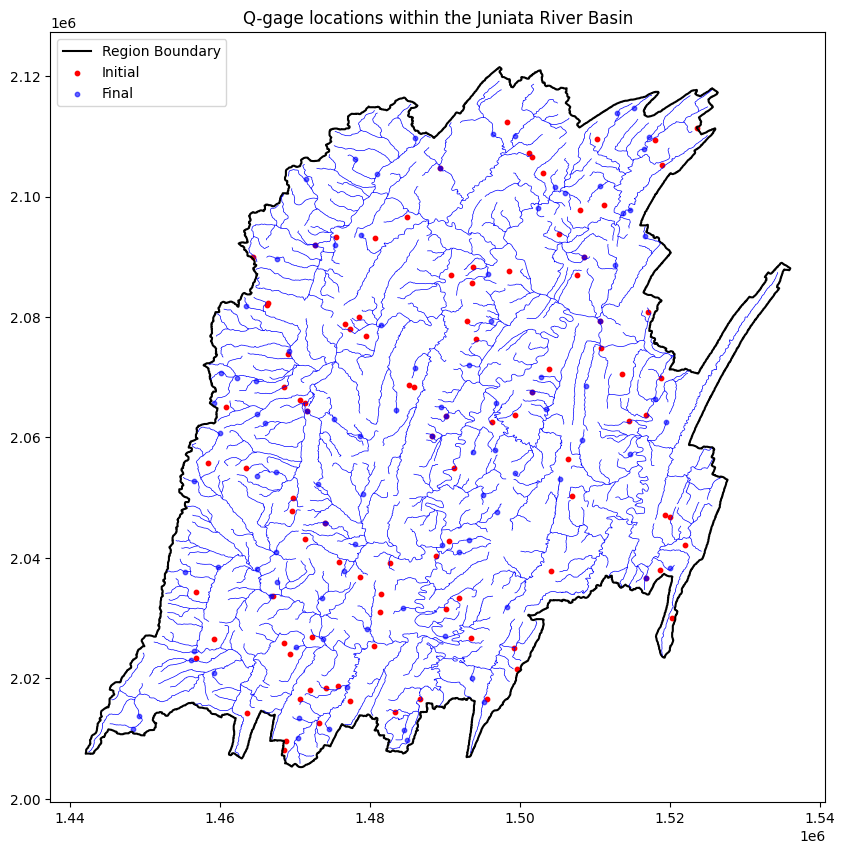

In [ ]:
live_plot([(point.x, point.y) for point in points0], points_pred, boundary, flowpaths)

In [ ]:
f = MultiLineString(
    [line.geometry for line in flowpaths.geometry if line.geom_type == 'LineString' or line.geom_type == 'MultiLineString']
)
f.distance

AttributeError: 'LineString' object has no attribute 'geometry'